In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:
data_path = '/content/drive/My Drive/emotion detection/ravdess-hifi'


In [4]:
import numpy as np

def augment_data(audio, sample_rate):
    augmented_data = []

    # Time Stretching
    augmented_data.append(librosa.effects.time_stretch(audio, rate=1.2))
    augmented_data.append(librosa.effects.time_stretch(audio, rate=0.8))

    # Pitch Shifting
    augmented_data.append(librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=2))
    augmented_data.append(librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=-2))

    # Adding noise
    noise = np.random.randn(len(audio))
    augmented_data.append(audio + 0.005 * noise)

    # Time Shifting
    shift_range = int(np.random.uniform(low=-5, high=5) * sample_rate)
    augmented_data.append(np.roll(audio, shift_range))

    return augmented_data

def extract_features_and_emotions(directory):
    features = []
    emotions = []
    emotion_dict = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    for actor in os.listdir(directory):
        actor_folder = os.path.join(directory, actor)
        if os.path.isdir(actor_folder):
            for file in os.listdir(actor_folder):
                if file.endswith('.wav'):
                    file_path = os.path.join(actor_folder, file)
                    audio_data, sample_rate = librosa.load(file_path)
                    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
                    mfccs_scaled = np.mean(mfccs.T, axis=0)
                    features.append(mfccs_scaled)
                    emotion_code = file.split('-')[2]
                    emotions.append(emotion_dict[emotion_code])

                    # Data augmentation
                    augmented_audios = augment_data(audio_data, sample_rate)
                    for aug_audio in augmented_audios:
                        mfccs_aug = librosa.feature.mfcc(y=aug_audio, sr=sample_rate, n_mfcc=13)
                        mfccs_aug_scaled = np.mean(mfccs_aug.T, axis=0)
                        features.append(mfccs_aug_scaled)
                        emotions.append(emotion_dict[emotion_code])

    return np.array(features), np.array(emotions)

# Extract features and emotions with augmented data
features, emotions = extract_features_and_emotions(data_path)



In [5]:
# Create a DataFrame
data = pd.DataFrame(features)
data['emotion'] = emotions

# Save to CSVm
csv_path = '/content/drive/My Drive/emotion detection/ravdess_emotion_features.csv'
data.to_csv(csv_path, index=False)

# Load the saved features and emotions
data = pd.read_csv(csv_path)


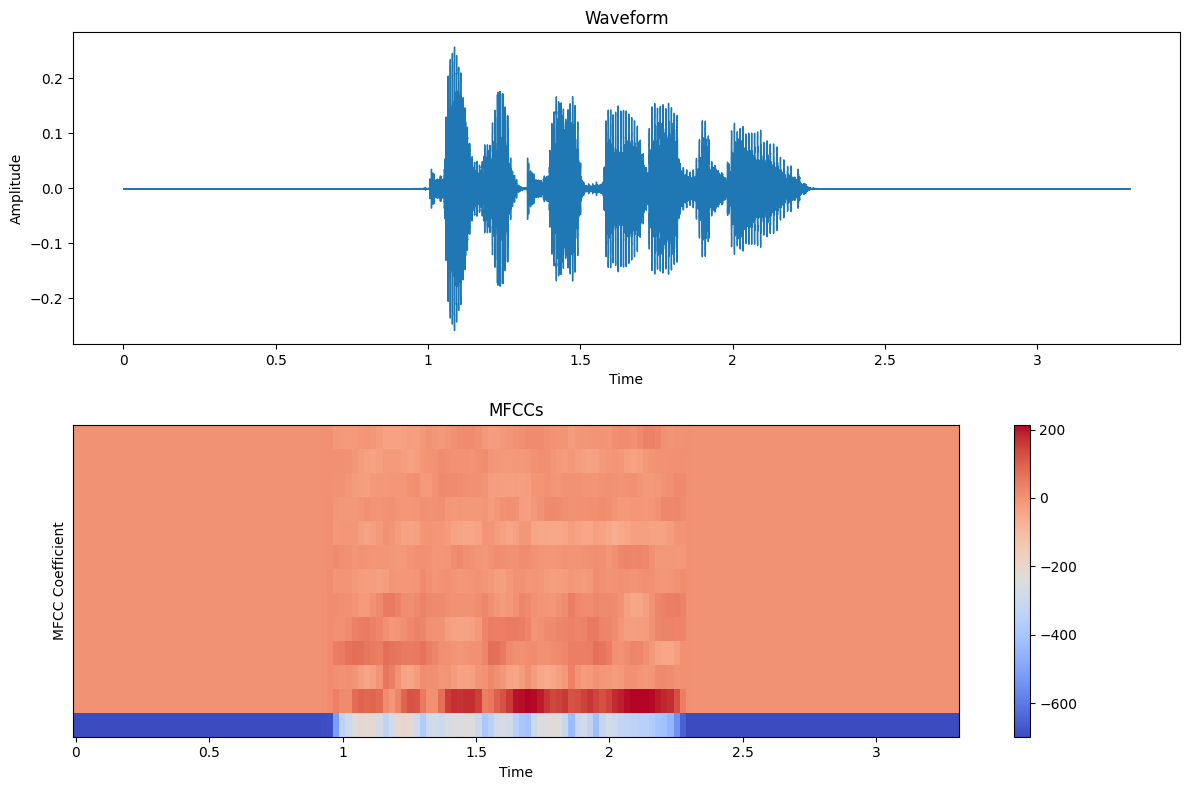

In [6]:
import librosa.display
import matplotlib.pyplot as plt

def plot_example(file_path):
    audio_data, sample_rate = librosa.load(file_path)
    plt.figure(figsize=(12, 8))

    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio_data, sr=sample_rate)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot MFCCs
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')

    plt.tight_layout()
    plt.show()

# Example usage
file_path = '/content/drive/My Drive/emotion detection/ravdess-hifi/Actor_01/03-01-01-01-01-01-01.wav'
plot_example(file_path)


In [7]:
# Separate features and labels
X = data.drop(columns=['emotion']).values
y = data['emotion'].values

# Encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, shuffle=True)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for CNN input
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [15]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(13, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,808 (237.53 KB)

 Trainable params: 60,424 (236.03 KB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
history = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_test, y_test))

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1] * 100
print(f"Accuracy of our model on test data: {accuracy:.2f}%")

Epoch 1/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3921 - loss: 1.5763 - val_accuracy: 0.4540 - val_loss: 1.4494
Epoch 2/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4152 - loss: 1.5327 - val_accuracy: 0.4671 - val_loss: 1.4206
Epoch 3/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4197 - loss: 1.5054 - val_accuracy: 0.4702 - val_loss: 1.3884
Epoch 4/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4244 - loss: 1.4958 - val_accuracy: 0.4806 - val_loss: 1.3687
Epoch 5/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4536 - loss: 1.4488 - val_accuracy: 0.4980 - val_loss: 1.3501
Epoch 6/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4448 - loss: 1.4698 - val_accuracy: 0.4909 - val_loss: 1.3445
Epoch 7/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4445 - loss: 1.4623 - val_accuracy: 0.4897 - val_loss: 1.3242
Epoch 8/300
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4732 - loss: 1.3893 - val

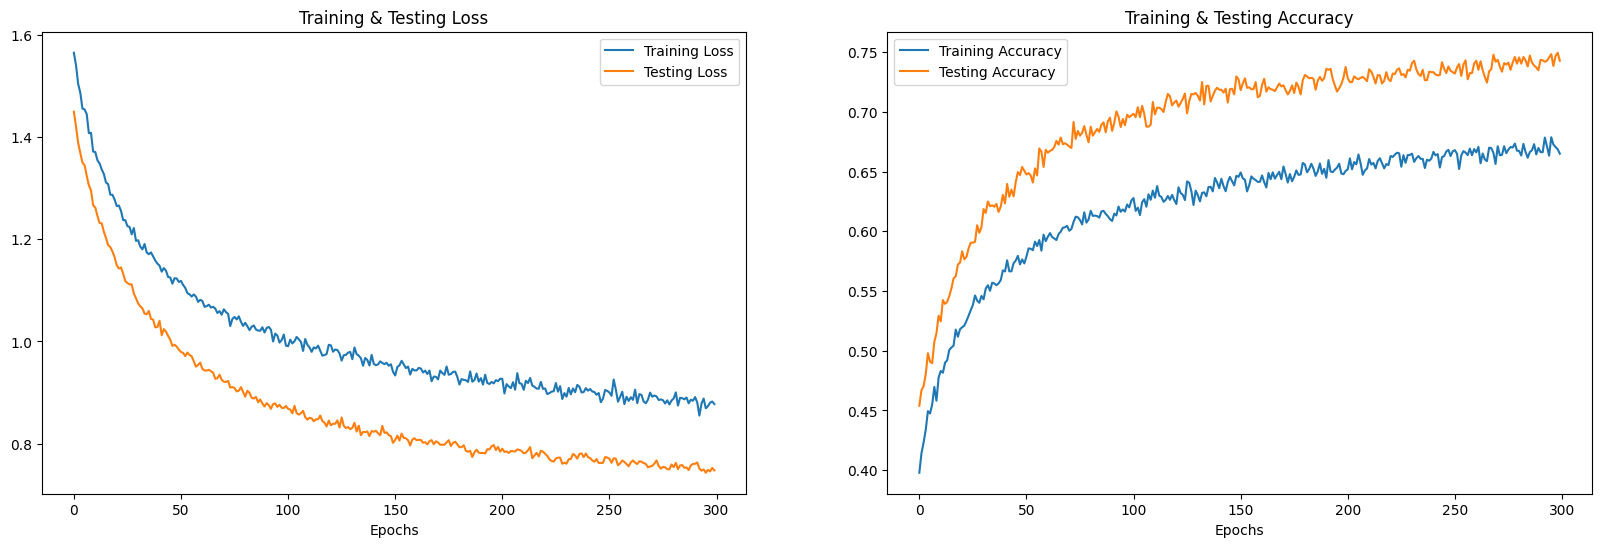

In [18]:
# Plotting the results
epochs = range(len(history.history['accuracy']))
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()


In [19]:
# Predictions and confusion matrix
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test_labels = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_labels.flatten()

print(df.head(10))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Predicted Labels Actual Labels
0          fearful       fearful
1          disgust       disgust
2             calm          calm
3            happy         happy
4          disgust       disgust
5              sad           sad
6             calm          calm
7            happy         happy
8            angry         angry
9          fearful       fearful


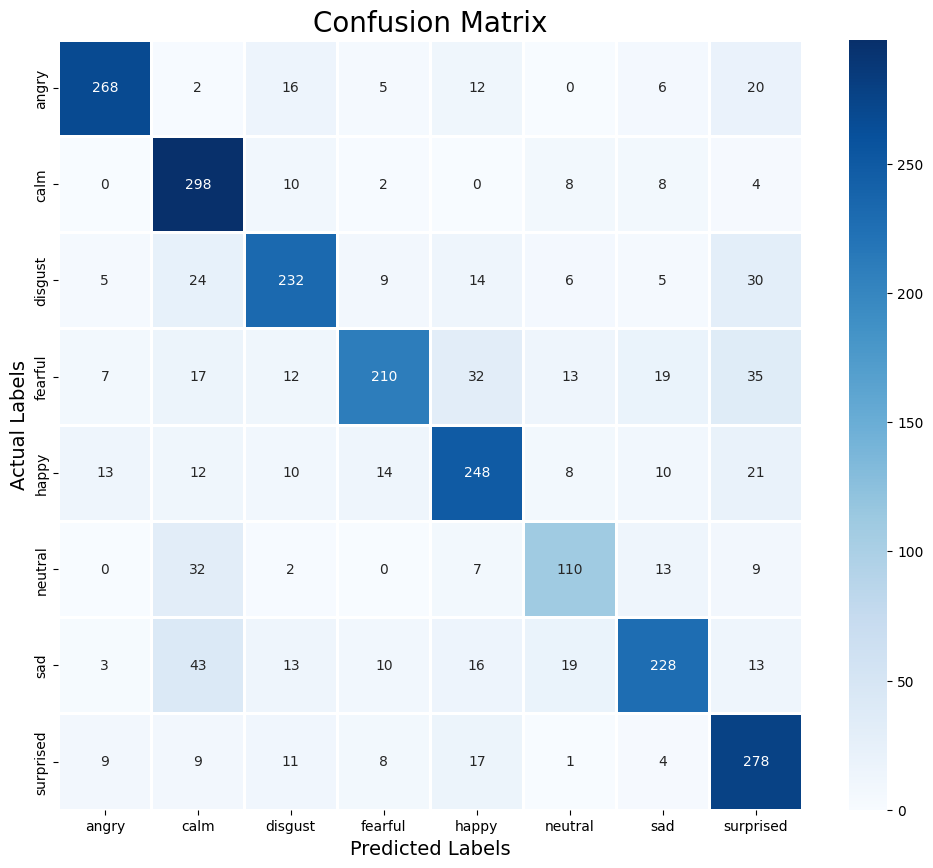

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])
sns.heatmap(cm_df, annot=True, fmt='', cmap='Blues', linecolor='white', linewidths=1)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [23]:
import librosa
import numpy as np

def predict_emotion(file_path, model, encoder, scaler):
    audio_data, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    mfccs_scaled = np.mean(mfccs.T, axis=0)

    # Reshape and scale the features
    mfccs_scaled = scaler.transform(mfccs_scaled.reshape(1, -1))
    mfccs_scaled = np.expand_dims(mfccs_scaled, axis=2)

    # Make prediction
    prediction = model.predict(mfccs_scaled)
    predicted_emotion = encoder.inverse_transform(prediction)[0][0]  # Get the predicted emotion label

    return predicted_emotion

new_audio_file = '/content/drive/My Drive/emotion detection/test.wav'

predicted_label = predict_emotion(new_audio_file, model, encoder, scaler)
print(f"Predicted emotion for {new_audio_file}: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted emotion for /content/drive/My Drive/emotion detection/test.wav: happy
